In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, \
                             StackingClassifier, VotingClassifier, AdaBoostClassifier, \
                             GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb

sns.set_theme(palette=sns.color_palette("Set2"), rc={'figure.figsize':(15,6)})

# Data processing

## Research

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
print(train.shape)
train.head(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
print(test.shape)
test.head(10)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Handling missing values and data engineering

In [4]:
def count_na(column):
    print(f"Train dataset: number of NA in {column} = {train[column].isna().sum()}")
    print(f"Test dataset: number of NA in {column} = {test[column].isna().sum()}")

### Name

In [5]:
count_na("Name")
train[["Name"]].head()

Train dataset: number of NA in Name = 0
Test dataset: number of NA in Name = 0


,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


Let's get the title from the name and make a new feature with 4 main titles and others(called Rare)

In [6]:
train['Title'] = train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
test['Title'] = test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

rare_titles_train = train.Title.value_counts().index[4:]
rate_titles_test = test.Title.value_counts().index[4:]

train.Title.replace(rare_titles_train, 'Rare', inplace=True)
test.Title.replace(rate_titles_test, 'Rare', inplace=True)

train.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

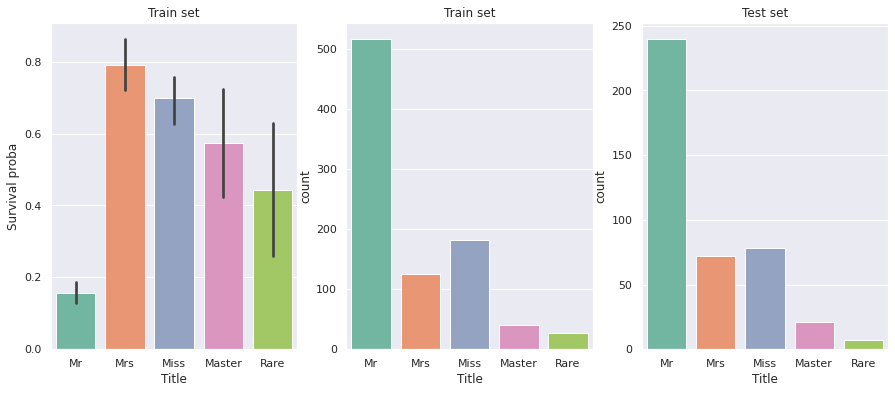

In [7]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='Title', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='Title', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='Title', ax=axes[2])
_ = g.set_title('Test set')

Summary: 
* feature distributions is similar in train and test sets
* obviously, women have more survival proba

### Sex

In [8]:
count_na("Sex")

Train dataset: number of NA in Sex = 0
Test dataset: number of NA in Sex = 0


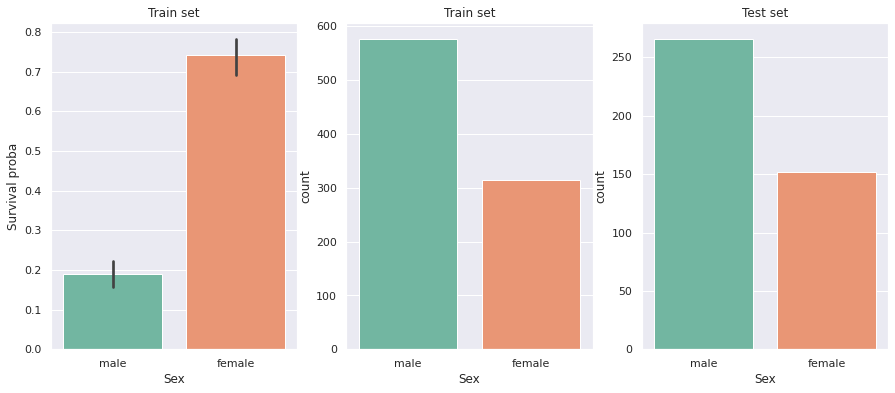

In [9]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='Sex', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='Sex', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='Sex', ax=axes[2])
_ = g.set_title('Test set')

Summary:
* as in the previous paragraph, we see high survival prova among women
* feauter distribution is similar in train and test sets

In [10]:
# Applying label encoding
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} )
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} )

## Ticket

In [11]:
count_na("Ticket")

Train dataset: number of NA in Ticket = 0
Test dataset: number of NA in Ticket = 0


In [12]:
train['Ticket_Frequency'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Ticket_Frequency'] = test.groupby('Ticket')['Ticket'].transform('count')

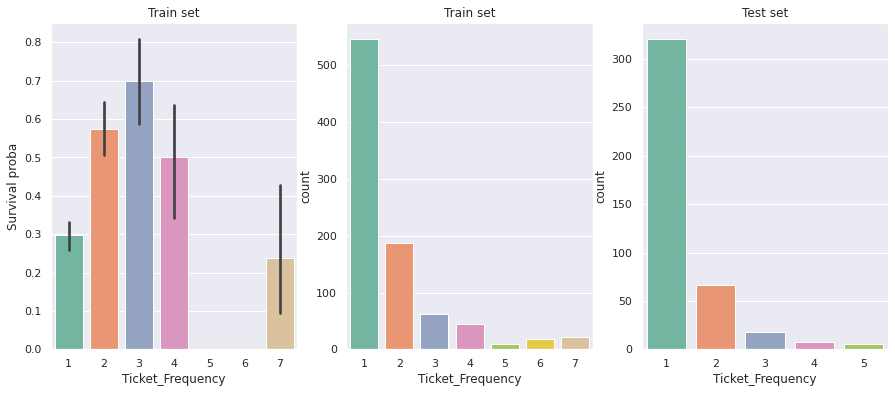

In [13]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='Ticket_Frequency', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='Ticket_Frequency', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='Ticket_Frequency', ax=axes[2])
_=g.set_title('Test set')

This feature is created for the reason that it shows how many satellites a person had, in addition to his family. As will be shown later, it does not fully correlate with the size of the family, and therefore carries useful information.

### SibSp Parch

In [14]:
count_na("SibSp")
count_na("Parch")

Train dataset: number of NA in SibSp = 0
Test dataset: number of NA in SibSp = 0
Train dataset: number of NA in Parch = 0
Test dataset: number of NA in Parch = 0


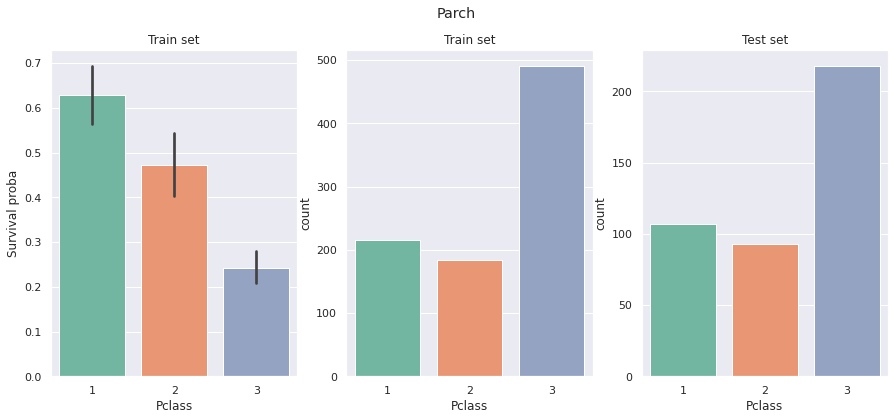

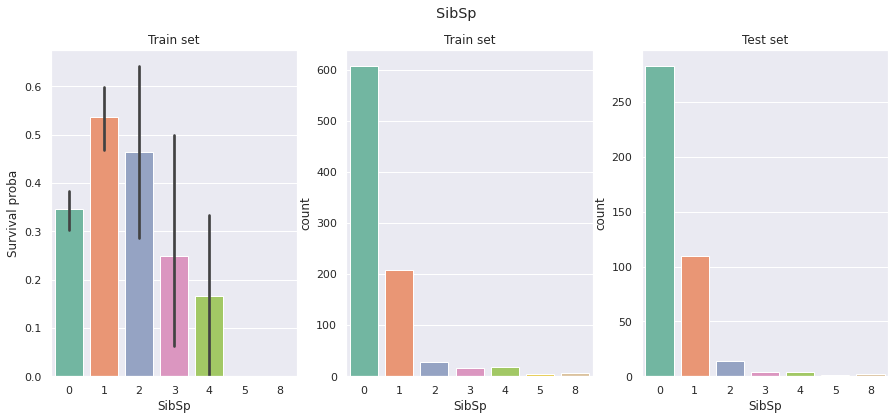

In [15]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='Pclass', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='Pclass', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='Pclass', ax=axes[2])
g.set_title('Test set')
plt.suptitle("Parch")

fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='SibSp', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='SibSp', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='SibSp', ax=axes[2])
g.set_title('Test set')
_=plt.suptitle("SibSp")

Summary: small families (2-4 persons) had more survival proba. Suppose they were given a priority during evacuation.

In [16]:
train['FamilySize'] = train.Parch + train.SibSp + 1
test['FamilySize'] = test.Parch + test.SibSp + 1

In [17]:
train[["Ticket_Frequency", "FamilySize"]].corr()

,Ticket_Frequency,FamilySize
Ticket_Frequency,1.000000,0.748487
FamilySize,0.748487,1.000000


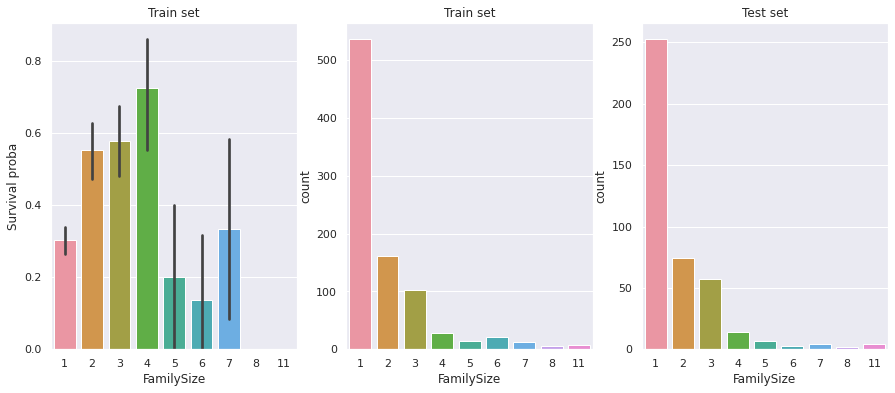

In [18]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='FamilySize', y='Survived', ax=axes[0])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='FamilySize', ax=axes[1])
g.set_title("Train set")
g = sns.countplot(data=test, x='FamilySize', ax=axes[2])
_=g.set_title('Test set')


We will bin family size according to plot

In [19]:
fam_map = {1: "Alone", 2: "Small", 3: "Small", 4: "Small", 5: "Medium", 6: "Medium",
           7: "Large", 8: "Large", 11: "Large"}

train['FamilySize'] = train['FamilySize'].map(fam_map)
test['FamilySize'] = test['FamilySize'].map(fam_map)

### Fare

In [20]:
count_na("Fare")

Train dataset: number of NA in Fare = 0
Test dataset: number of NA in Fare = 1


In [21]:
test[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_Frequency,FamilySize
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NaN,S,Mr,1,Alone


In [22]:
med_fare = test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
test['Fare'] = test['Fare'].fillna(med_fare)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

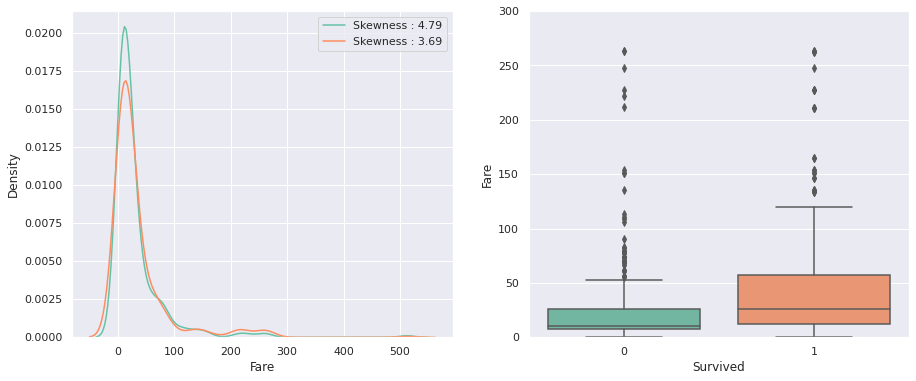

In [23]:
fig, axes = plt.subplots(1, 2)
axes[1].set_ylim(0, 300)
sns.kdeplot(train["Fare"], label="Skewness : %.2f"%(train["Fare"].skew()), ax=axes[0])
sns.kdeplot(test["Fare"], label="Skewness : %.2f"%(test["Fare"].skew()), ax=axes[0])
axes[0].legend()
sns.boxplot(data=train, x='Survived', ax=axes[1], y='Fare')

The distribution is very skewed, so this feature also needs binning .

In [24]:
train["Fare"] = pd.qcut(train["Fare"], 13)
test["Fare"] = pd.qcut(test["Fare"], 13)

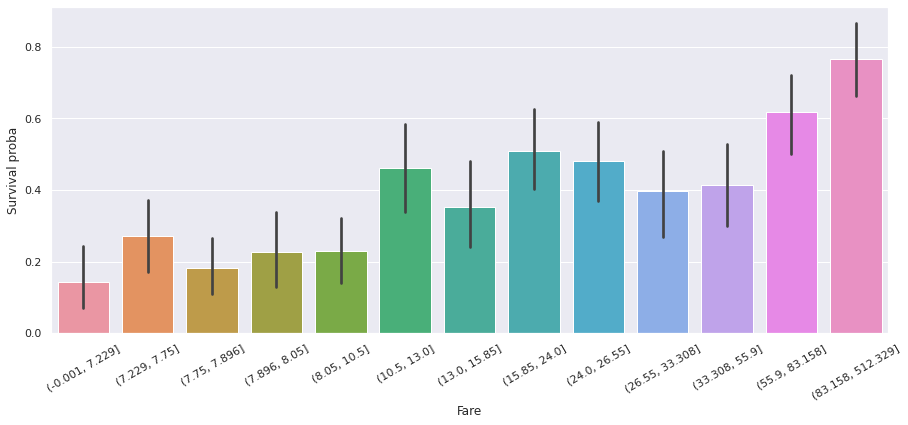

In [25]:
fig, axes = plt.subplots(1, 1)
g = sns.barplot(data=train, x='Fare', y='Survived', ax=axes)
g.set_ylabel("Survival proba")
_=plt.xticks(rotation=30)

In [26]:
train["Fare"] = LabelEncoder().fit_transform(train["Fare"])
test["Fare"] = LabelEncoder().fit_transform(test["Fare"])

### Cabin

In [27]:
count_na("Cabin")

Train dataset: number of NA in Cabin = 687
Test dataset: number of NA in Cabin = 327


Skipped values are replaced my new value "X"

In [28]:
train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train['Cabin'] ])
test["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test['Cabin'] ])

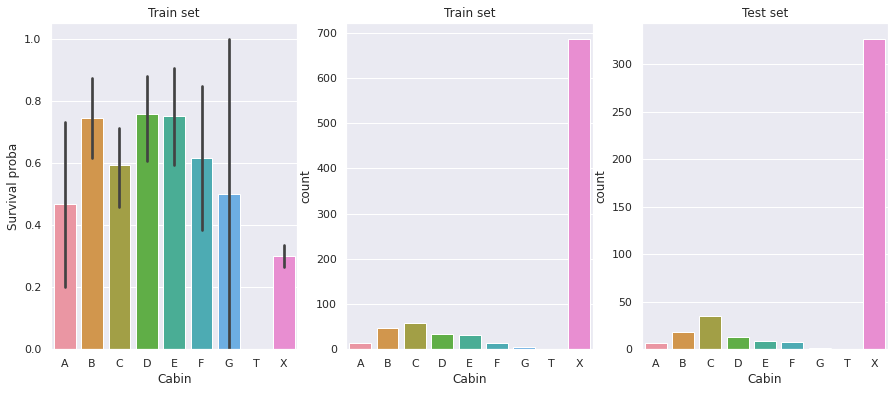

In [29]:
fig, axes = plt.subplots(1, 3)
g = sns.barplot(data=train, x='Cabin', y='Survived', ax=axes[0], order=['A','B','C','D','E','F','G','T','X'])
g.set_ylabel("Survival proba")
g.set_title("Train set")
g = sns.countplot(data=train, x='Cabin', ax=axes[1], order=['A','B','C','D','E','F','G','T','X'])
g.set_title("Train set")
g = sns.countplot(data=test, x='Cabin', ax=axes[2], order=['A','B','C','D','E','F','G','T','X'])
_=g.set_title('Test set')

In [30]:
cabin_dist = pd.crosstab(train['Cabin'], train['Pclass'])
cabin_sum = cabin_dist.sum(axis=1)
cabin_dist = cabin_dist.apply(lambda x: x / cabin_sum)


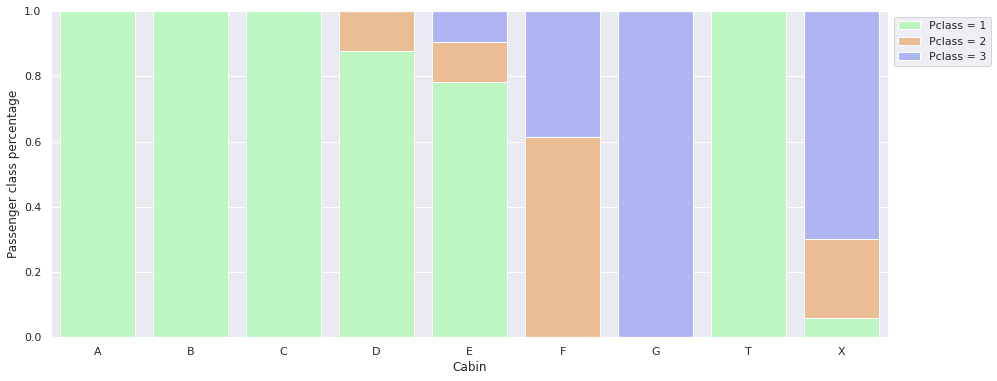

In [31]:
sns.barplot(x=cabin_dist.index, y=cabin_dist[1], label = "Pclass = 1", color='#b5ffb9', edgecolor='white')
sns.barplot(x=cabin_dist.index, y=cabin_dist[2], label = "Pclass = 2", bottom=cabin_dist[1], color='#f9bc86', edgecolor='white')
sns.barplot(x=cabin_dist.index, y=cabin_dist[3], label = "Pclass = 3", bottom=cabin_dist[1] + cabin_dist[2], color='#a3acff', edgecolor='white')
plt.ylabel("Passenger class percentage")
plt.legend(bbox_to_anchor=(1, 1))

As "A", "B", "C" fully consist of 1 class passengers, we will connect them. For similar reasons, we will replace the remaining values. And we will replace the only deck T with A, since they are next to each other on the ship.

In [32]:
# Passenger in the T deck is changed to A
train.loc[train['Cabin'] == 'T', 'Cabin'] = 'A'

In [33]:
train['Cabin'] = train['Cabin'].replace(['A', 'B', 'C'], 'ABC')
train['Cabin'] = train['Cabin'].replace(['D', 'E'], 'DE')
train['Cabin'] = train['Cabin'].replace(['F', 'G'], 'FG')

test['Cabin'] = test['Cabin'].replace(['A', 'B', 'C'], 'ABC')
test['Cabin'] = test['Cabin'].replace(['D', 'E'], 'DE')
test['Cabin'] = test['Cabin'].replace(['F', 'G'], 'FG')

train['Cabin'].value_counts()

X      687
ABC    122
DE      65
FG      17
Name: Cabin, dtype: int64

From this table we can understand, that the fact of having or not having cabin is important feature

### Embarked

In [34]:
count_na("Embarked")

Train dataset: number of NA in Embarked = 2
Test dataset: number of NA in Embarked = 0


<AxesSubplot:xlabel='Pclass', ylabel='count'>

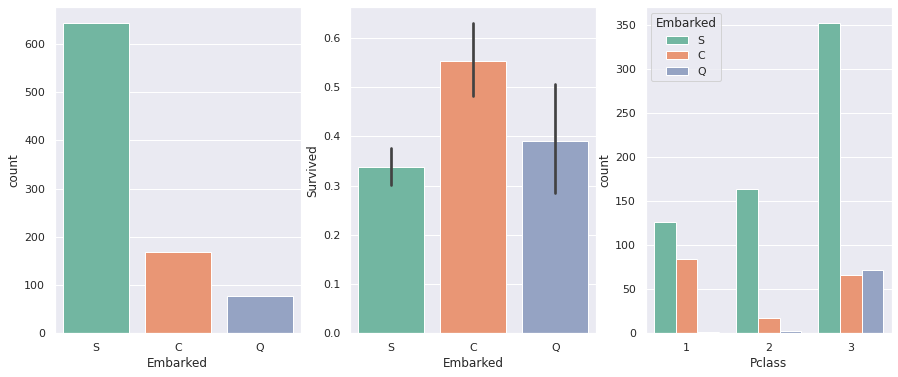

In [35]:
fig, axes = plt.subplots(1, 3)
sns.countplot(data=train, x='Embarked', ax=axes[0])
sns.barplot(data=train, x='Embarked', y='Survived', ax=axes[1])
sns.countplot(data=train, x='Pclass', hue='Embarked', ax=axes[2])

In [36]:
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

Suppose, that high survival rate among embarked "C" is caused by correlation of this feature with Passenger class

### Age

In [37]:
print(train.Age.describe())
print("-" * 30)
print(test.Age.describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
------------------------------
count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64


In [38]:
count_na("Age")

Train dataset: number of NA in Age = 177
Test dataset: number of NA in Age = 86


<AxesSubplot:xlabel='Cabin', ylabel='Age'>

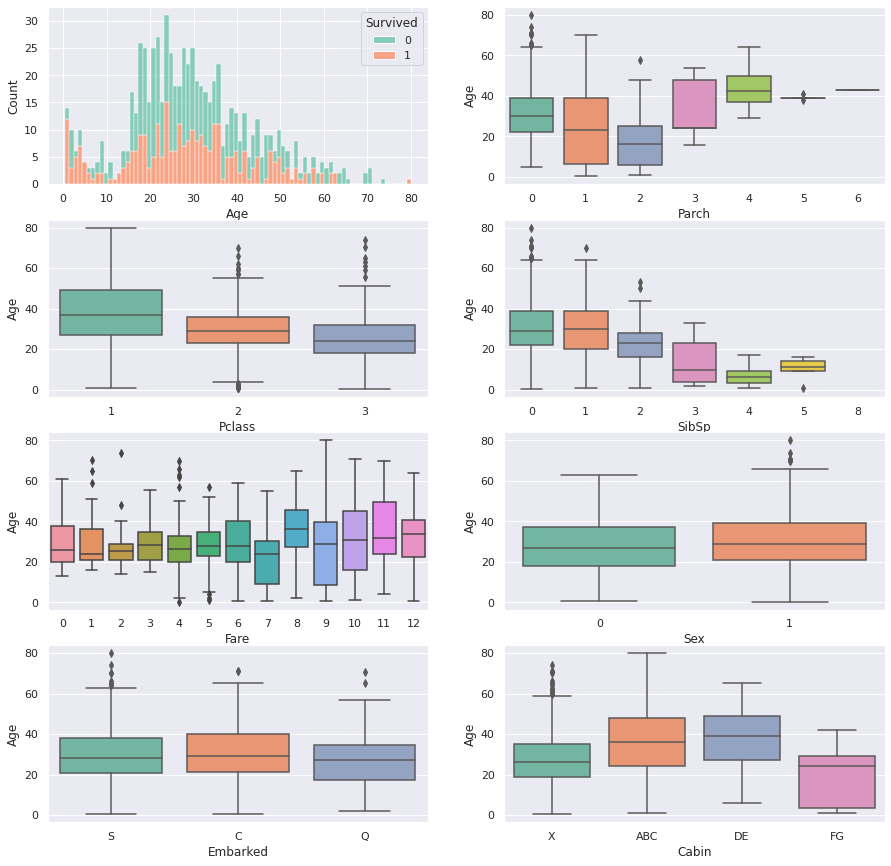

In [39]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
sns.histplot(data=train, x='Age',ax=axes[0, 0], multiple="stack", hue='Survived', bins=80)
sns.boxplot(data=train, x='Parch', ax=axes[0, 1], y='Age')
sns.boxplot(data=train, x='Pclass', ax=axes[1, 0], y='Age')
sns.boxplot(data=train, x='SibSp', ax=axes[1, 1], y='Age')
sns.boxplot(data=train, x='Fare', ax=axes[2, 0], y='Age')
sns.boxplot(data=train, x='Sex', ax=axes[2, 1], y='Age')
sns.boxplot(data=train, x='Embarked', ax=axes[3, 0], y='Age')
sns.boxplot(data=train, x='Cabin', ax=axes[3, 1], y='Age')

In [40]:
train[['Age', 'Parch', 'SibSp', 'Fare', 'Pclass', 'Cabin', 'Sex']].corr()

,Age,Parch,SibSp,Fare,Pclass,Sex
Age,1.000000,-0.189119,-0.308247,0.106712,-0.369226,0.093254
Parch,-0.189119,1.000000,0.414838,0.370985,0.018443,-0.245489
SibSp,-0.308247,0.414838,1.000000,0.366899,0.083081,-0.114631
Fare,0.106712,0.370985,0.366899,1.000000,-0.691988,-0.257943
Pclass,-0.369226,0.018443,0.083081,-0.691988,1.000000,0.131900
Sex,0.093254,-0.245489,-0.114631,-0.257943,0.131900,1.000000


Let's fill missing values of age with median among Pclass and Sex

In [41]:
train['Age'] = train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

And also bin it

In [42]:
train['Age'] = pd.qcut(train['Age'], 10)
test['Age'] = pd.qcut(test['Age'], 10)

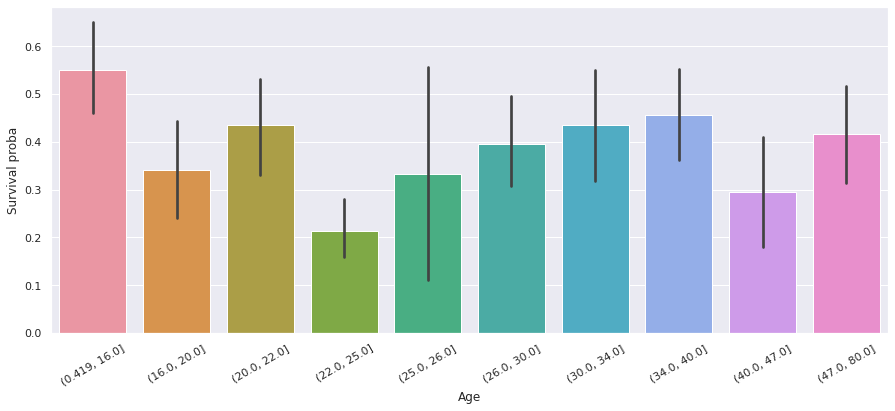

In [43]:
fig, axes = plt.subplots(1, 1)
g = sns.barplot(data=train, x='Age', y='Survived', ax=axes)
g.set_ylabel("Survival proba")
_=plt.xticks(rotation=30)

In [44]:
train["Age"] = LabelEncoder().fit_transform(train["Age"])
test["Age"] = LabelEncoder().fit_transform(test["Age"])

### Result

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_Frequency,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,1,X,S,Mr,1,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,7,1,0,PC 17599,11,ABC,C,Mrs,1,Small
2,3,1,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,3,X,S,Miss,1,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,7,1,0,113803,10,ABC,S,Mrs,2,Small
4,5,0,3,"Allen, Mr. William Henry",1,7,0,0,373450,3,X,S,Mr,1,Alone


In [46]:
PassengerId = test['PassengerId']
drop_feat = ['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch']

train.drop(drop_feat, axis=1, inplace=True)
test.drop(drop_feat, axis=1, inplace=True)

In [47]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Ticket_Frequency,FamilySize
0,0,3,1,2,1,X,S,Mr,1,Small
1,1,1,0,7,11,ABC,C,Mrs,1,Small
2,1,3,0,4,3,X,S,Miss,1,Alone
3,1,1,0,7,10,ABC,S,Mrs,2,Small
4,0,3,1,7,3,X,S,Mr,1,Alone


# Training

In [48]:
train["FamilySize"] = LabelEncoder().fit_transform(train["FamilySize"])
test["FamilySize"] = LabelEncoder().fit_transform(test["FamilySize"])

In [49]:
X_train = pd.get_dummies(train.drop('Survived', axis=1), columns=['Cabin', 'Embarked', 'Title'])
X_test = pd.get_dummies(test, columns=['Cabin', 'Embarked', 'Title'])

y_train = train['Survived']

In [50]:
X_train.head()

,Pclass,Sex,Age,Fare,Ticket_Frequency,FamilySize,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,1,2,1,1,3,0,0,0,1,0,0,1,0,0,1,0,0
1,1,0,7,11,1,3,1,0,0,0,1,0,0,0,0,0,1,0
2,3,0,4,3,1,0,0,0,0,1,0,0,1,0,1,0,0,0
3,1,0,7,10,2,3,1,0,0,0,0,0,1,0,0,0,1,0
4,3,1,7,3,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [51]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_train[:5]

array([[ 0.82737724,  0.73769513, -0.80682091, -1.29985522, -0.57916179,
         1.36604236, -0.39830591, -0.28052182, -0.13946613,  0.54492498,
        -0.48204268, -0.30756234,  0.61583843, -0.21680296, -0.50665528,
         0.85053175, -0.4039621 , -0.1767767 ],
       [-1.56610693, -1.35557354,  0.93043726,  1.34678783, -0.57916179,
         1.36604236,  2.51063313, -0.28052182, -0.13946613, -1.835115  ,
         2.0745051 , -0.30756234, -1.62380254, -0.21680296, -0.50665528,
        -1.17573506,  2.47547975, -0.1767767 ],
       [ 0.82737724, -1.35557354, -0.11191764, -0.77052661, -0.57916179,
        -0.78438828, -0.39830591, -0.28052182, -0.13946613,  0.54492498,
        -0.48204268, -0.30756234,  0.61583843, -0.21680296,  1.97372855,
        -1.17573506, -0.4039621 , -0.1767767 ],
       [-1.56610693, -1.35557354,  0.93043726,  1.08212353,  0.15592818,
         1.36604236,  2.51063313, -0.28052182, -0.13946613, -1.835115  ,
        -0.48204268, -0.30756234,  0.61583843, -0.216

In [52]:
def evaluate(clf, X, y):
    cv_results = cross_validate(clf, X, y, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    print(f'accuracy = {np.mean(cv_results["test_accuracy"]):.4f}')
    print(f'precision = {np.mean(cv_results["test_precision"]):.4f}')
    print(f'recall = {np.mean(cv_results["test_recall"]):.4f}')
    print(f'f1 = {np.mean(cv_results["test_f1"]):.4f}')
    print(f'roc_auc = {np.mean(cv_results["test_roc_auc"]):.4f}')

In [53]:
def save_result(predictions, sub_name):
    output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
    output.to_csv('submission' + sub_name + '.csv', index=False)
    print("Your submission was successfully saved!")

In [54]:
def add_stats(df, clf, X, y, name):
    cv_results = cross_validate(clf, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    acc = np.mean(cv_results["test_accuracy"]).round(4)
    prec = np.mean(cv_results["test_precision"]).round(4)
    rec = np.mean(cv_results["test_recall"]).round(4)
    f1 = np.mean(cv_results["test_f1"]).round(4)
    roc_auc = np.mean(cv_results["test_roc_auc"]).round(4)
    df[name] = [acc, prec, rec, f1, roc_auc]
    return df


### Models overview

In [55]:
classifiers = [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(),
               KNeighborsClassifier(), GaussianNB(), LogisticRegression(solver='liblinear'), AdaBoostClassifier(),
               GradientBoostingClassifier(), LinearDiscriminantAnalysis(), SVC(),
               xgb.XGBClassifier()]

names = ['DecisionTree', 'RandomForest', 'ExtraTrees',
         'KNeighbors', 'GaussianNB', 'LogisticRegression', 'AdaBoost',
         'GradientBoosting', 'LDA', 'SVC', 'XGBoost']

model_compar_base = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

for clf, clf_name in zip(classifiers, names):
    clf.fit(X_train, y_train)
    model_compar_base = add_stats(model_compar_base, clf, X_train, y_train,clf_name)
    

<AxesSubplot:xlabel='AUC'>

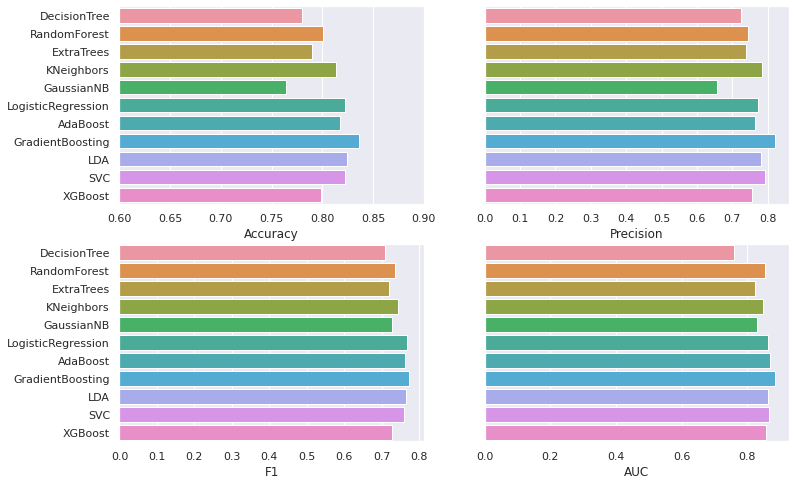

In [56]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 8))
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='Accuracy', orient='horizont', ax=axes[0][0])
axes[0][0].set_xlim(0.6, 0.9)
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='Precision', orient='horizont', ax=axes[0][1])
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='F1', orient='horizont', ax=axes[1][0])
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='AUC', orient='horizont', ax=axes[1][1])

It seems that Gradient Boosting and Logistic Regresstion are good choices but in practise they give low ressult on test even after tuning (this can be said for many models). Finally I choosed Random Forest. And AdaBoost with LR for ensembling.

## Random Forrest

In [57]:
model_compar = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

TRAIN = False
if TRAIN:
    param_grid = { 
        'n_estimators': [100, 300, 500, 700, 1000],
        'max_features': ['auto', 'log2'],
        'max_depth': [5, 7, 9, 11, 13, 15],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
    }

    model = RandomForestClassifier()
    rscv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1,
                              scoring='accuracy', refit=True, verbose=10)
    rscv.fit(X_train, y_train)

    rf_params = rscv.best_params_
    print(rscv.best_params_)
    print(rscv.best_score_)

    model_compar = add_stats(model_compar, rscv.best_estimator_, X_train, y_train, 'RandomForrest')

In [58]:
SEED = 42
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=0)

## AdaBoost parameters

In [59]:
if TRAIN:
    param_grid = { 
        'n_estimators': [100, 500, 1000, 1250, 1500, 1750, 2000],
        'learning_rate': np.arange(0.1, 1.05, 0.05),
    }

    model = AdaBoostClassifier()
    rscv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1,
                              scoring='auc', refit=True)
    rscv.fit(X_train, y_train)

    ada_params = rscv.best_params_
    print(rscv.best_params_)
    print(rscv.best_score_)

In [60]:
ada_params = {'n_estimators': 100, 'learning_rate': 0.65}
preds = AdaBoostClassifier(**ada_params).fit(X_train, y_train).predict(X_test)
save_result(preds, 'Ada')

Your submission was successfully saved!


## Logistic regression

In [61]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.025, 0.05, 0.1, 0.5, 1],
    'solver' : ['liblinear']
}

model = LogisticRegression()
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1,
                  scoring='roc_auc', refit=True)
gs.fit(X_train, y_train)

logreg_params = gs.best_params_
print(gs.best_params_)
print(gs.best_score_)
model_compar_base = add_stats(model_compar_base, gs.best_estimator_, X_train, y_train, 'LogReg')

{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
0.8659800810849052


## Voting Classifier

In [62]:
estimators = [('rf', single_best_model),
              ('logreg', LogisticRegression(**logreg_params)),
              ('ada', AdaBoostClassifier(**ada_params))]

voter_hard = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
voter_soft = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

voter_soft.fit(X_train, y_train)
voter_hard.fit(X_train, y_train)

preds_soft = voter_soft.predict(X_test)
preds_hard = voter_hard.predict(X_test)

model_compar_base = add_stats(model_compar_base, voter_soft, X_train, y_train, 'Voter_soft')

print(voter_soft.score(X_train, y_train))
print(voter_hard.score(X_train, y_train))

0.8451178451178452
0.8406285072951739


In [63]:
preds = voter_soft.predict(X_test)
save_result(preds, 'Soft')
preds = voter_hard.predict(X_test)
save_result(preds, 'Hard')

Your submission was successfully saved!
Your submission was successfully saved!


## Stacking

In [64]:
if TRAIN:
    estimators = [('rf', RandomForestClassifier(**rf_params)),
                  ('ada', AdaBoostClassifier(**ada_params)), 
                  ('lda', LinearDiscriminantAnalysis()),
                  ('xgb', xgb.XGBClassifier())]

    clf_stack = StackingClassifier(estimators=estimators, 
                                   final_estimator = LogisticRegression(solver='liblinear'), 
                                   stack_method = 'predict_proba', passthrough = True)

    param_grid = {
        'passthrough': [True, False],
        'final_estimator__penalty': ['l1', 'l2'],
        'final_estimator__fit_intercept': [True, False],
        'final_estimator__C' : [0.001, 0.01, 0.1, 0.5, 1]

    }

    gs = GridSearchCV(estimator=clf_stack, param_grid=param_grid, cv=3, n_jobs=-1,
                      scoring='accuracy', refit=True)

    gs.fit(X_train, y_train)
    preds = gs.best_estimator_.predict(X_test)

    model_compar = add_stats(model_compar, gs.best_estimator_, X_train, y_train, 'LogRegStack')
    evaluate(gs.best_estimator_, X_train, y_train)
    save_result(preds, 'LogReg stack')

This model gave too bad results, unfortunately